 * Most of the data columns are S.M.A.R.T. values that can vary in meaning based on the manufacturer and model. For this reason at this time limit the more in depth analysis to one identical drive model at a time 

In [1]:
import os
import sys
import math
import struct
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve


In [2]:
COLS = [u'date', u'failure', u'smart_1_raw', u'smart_3_raw', u'smart_4_raw',
       u'smart_5_raw', u'smart_7_raw', u'smart_9_raw', u'smart_10_raw',
       u'smart_12_raw', u'smart_183_raw', u'smart_184_raw', u'smart_187_raw',
       u'smart_188_raw', u'smart_189_raw', u'smart_190_raw', u'smart_191_raw',
       u'smart_192_raw', u'smart_193_raw', u'smart_194_raw', u'smart_197_raw',
       u'smart_198_raw', u'smart_199_raw', u'smart_240_raw', u'smart_241_raw',
       u'smart_242_raw', u'NaNs']

In [3]:
def get_run(disk):
    """
    Trys to get a contiguous run of days equal to DAY_BACK
    A contiguous set of days may not exist
    There could be too few days or the days may be not contiguous
    If day back lands at a day which does not exist, this must be handeled
    """
    try_count = 0
    while try_count < 6:
        ran_range = int(len(disk)  - DAY_BUFFER_FACTOR*DAY_BACK)
        if ran_range < 1:
            continue
        ran_num = np.random.randint(ran_range) +  DAY_BACK
        lastdayfrom = disk.index[ran_num]
        try:
            disk_run = disk.loc[lastdayfrom - pd.Timedelta(days=DAY_BACK):lastdayfrom].reset_index()
        except:
            #print "Landed on day that did not exist, trying again up to try_count"
            try_count +=1
            continue
        if len(disk_run) == DAY_BACK + 1:
            return disk_run
        else:
            #print "Got a range less than: ", DAY_BACK + 1
            try_count +=1
    return []

def get_failure_run(disk):
    """
    Trys to get a contiguous run of days equal to DAY_BACK for a disk that failed
    because few failures exist, do wahtever it takes to avoid these
    """
    disk_len = len(disk)
    if disk_len >= DAY_BACK:
        max_day_back = DAY_BACK
    else:
        max_day_back = disk_len
    disk = disk.set_index('date')
    try_count = 0
    avail_day_back = max_day_back
    while try_count < 5:
        lastdayfrom = disk.index[len(disk)-1]
        try:
            disk_run = disk.loc[lastdayfrom - pd.Timedelta(days=avail_day_back):lastdayfrom].reset_index()
            if len(disk_run) < max_day_back + 1 and avail_day_back < disk_len:
                print "days were not contiguous, but there are more days left in array", len(disk_run), avail_day_back, disk_len
                try_count += 1
                avail_day_back += 1
                continue
            else:
                # days were not contiguous and there are no more days in array
                return disk_run, _
        except:
            print "landed on a day that did not exist", avail_day_back, disk_len
            try_count +=1
            if avail_day_back < disk_len:
                avail_day_back += 1
                continue
            #break
            return [], "D"
    return [], "M"
                    

In [4]:
DAY_BACK = 62
TEST = False
DISTANT_DATE = pd.to_datetime("2020-01-01", format='%Y-%m-%d')
DAY_BUFFER_FACTOR = 1.5
# day  buffer factor takes into account that I don't want a drive that is within a day_back time of failure
# the larger day buffer the less likely we are too think a soon to be dead disk is a good disk
FAIL_PAST = True
DIR_PATH = "ST4000DM000_data"
directory = os.listdir(DIR_PATH)

col_len = len(COLS)
n_lost_failures = 0
n_lost_nominals = 0
n_incomplete_failures = 0
n_discontig_failures = 0
df = pd.DataFrame()
disk_bin = []
n = 0
for disk_file in directory:
    
    if disk_file.split('.')[1] != 'csv':
        continue
        
    n += 1
    if TEST and n > 12:
        break

    disk = pd.read_csv(DIR_PATH + '/' + disk_file, comment="#", header=0)# names=COLS)
    if len(disk.columns) != col_len:
        print "Oh no! ", disk_file , " has wacky columns!"
        continue
        
    disk['date'] = pd.to_datetime(disk['date'], format='%Y-%m-%d')        
    fail_day = disk['date'][disk['failure']>=1].values
    if len(fail_day) > 1:
        print "Oh no! ", disk_file , " is a zombie hard drive returning from dead!"
        continue
        
    if len(fail_day) == 0:
        fake_day = DISTANT_DATE
        disk['day2fail'] = fake_day - disk['date']
        if len(disk) > DAY_BUFFER_FACTOR * DAY_BACK:
            disk = disk.set_index('date')
            disk_run = get_run(disk) 
            if any(disk_run):
                disk_bin.append(disk_run)
            else:
                n_lost_nominals +=1
            
    if len(fail_day) == 1:
        print 'failure: ', disk_file
        disk['day2fail'] = fail_day[0] - disk['date']
        if FAIL_PAST == 1:
            disk['failure'] = 1
        disk_run, s = get_failure_run(disk)
        if s == "D":
            n_discontig_failures += 1
            continue
        if s == "M":
            n_incomplete_failures += 1
            continue
        if any(disk_run):
            disk_bin.append(disk_run)
        else:
            n_lost_failures +=1
        

failure:  Z300C8A4.csv
failure:  Z3029ACP.csv
failure:  Z3023X1H.csv
failure:  S301PSLG.csv
failure:  Z300P99L.csv
failure:  W300L073.csv
failure:  Z302G5F6.csv
failure:  W300D8TB.csv
failure:  S300WFMY.csv
days were not contiguous, but there are more days left in array 62 62 109
failure:  S300Z3QN.csv
failure:  Z3029H4P.csv
failure:  Z300WKKJ.csv
failure:  Z3025923.csv
failure:  Z3031QZE.csv
days were not contiguous, but there are more days left in array 62 62 78
failure:  Z300WWWP.csv
failure:  S300XB2L.csv
days were not contiguous, but there are more days left in array 62 62 188
failure:  Z300MGJK.csv
days were not contiguous, but there are more days left in array 61 62 519
days were not contiguous, but there are more days left in array 62 63 519
failure:  Z300GPJ0.csv
failure:  S300XL4J.csv
failure:  Z3029G1H.csv
failure:  Z302A19M.csv
failure:  W300R6KY.csv
failure:  W300THD2.csv
failure:  Z3006VN2.csv
failure:  Z300W356.csv
failure:  Z30111T0.csv
days were not contiguous, but the

Z300XJJ2.csv, Z300XH5X.csv had no values just commas for first 30 lines or so

Z30149QL.csv, has skips in data, no data for several days after 2014-07-20, then resumes normally

Z3025KZV.csv has a gap from 2014 to 2015 and smart9 resets

S300XCP4.csv had dates that didn't match the smart9 drive hours

In [5]:
print 'n_lost_nominals', n_lost_nominals
print 'n_lost_failures', n_lost_failures 
print 'incomplete failures: ', n_incomplete_failures 
print 'disctoninous failures: ', n_discontig_failures
print len(disk_bin)

n_lost_nominals 10
n_lost_failures 0
incomplete failures:  32
disctoninous failures:  4
36065


In [6]:
from sklearn import model_selection
from sklearn import metrics
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import Range1d
from bokeh.charts import Bar, output_file, show
from bokeh.models import ColumnDataSource, Plot, Range1d
from bokeh.models import HoverTool
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [7]:
def compute_error(estimator, X, y):
    cv = model_selection.ShuffleSplit(n_splits=2, test_size=0.3, random_state=np.random.randint(1,1000))
    cv_score = model_selection.cross_val_score(estimator, X, y, cv=cv, scoring='f1')
    print 'cross validated f1 scores: ', cv_score
    return cv_score.mean()


In [8]:

def get_important_RF(x,y, max_features, n_estimators):
    rfc = RandomForestClassifier(n_estimators=n_estimators, 
                                 min_samples_leaf = 8, 
                                 min_impurity_split=.1,
                                 min_weight_fraction_leaf=0,
                                 max_features= max_features,
                                 n_jobs = -1,
                                 bootstrap = True,
                                 oob_score = True)
    rfc.fit(x, y)
    importance = rfc.feature_importances_
    std_err = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
    indices = np.argsort(importance)[::-1]
    return importance, std_err, indices

    
def get_important_ETF(x,y, max_features, n_estimators):
    """
    Extra trees random forst reducdes variances increases bias
    Use forest classifier to find important features
    Get the indices and sort the labels of the important features
    """
    forest = ExtraTreesClassifier(n_estimators=n_estimators, criterion='gini', max_depth=None, min_samples_split=2,
                                  min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=max_features,
                                  max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=False,
                                  oob_score=False, n_jobs=-1, random_state=None, verbose=0, 
                                  warm_start=False, class_weight=None)
    forest.fit(x, y)
    importance = forest.feature_importances_
    std_err = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importance)[::-1]
    return importance, std_err, indices


def get_important(estimator, x,y):
    """
    Use estimator find important features
    Get the indices and sort the labels of the important features
    """
    estimator.fit(x, y)
    importance = estimator.feature_importances_
    std_err = np.std([tree.feature_importances_ for tree in estimator.estimators_], axis=0)
    indices = np.argsort(importance)[::-1]
    return importance, std_err, indices


In [9]:
def best_hyperparams(pipe, x, y, hyper1_range, hyper2_range, params, ptitle='junk.png'): 
    x_mesh_range = hyper1_range
    y_mesh_range = hyper2_range

    x_mesh, y_mesh = np.meshgrid(x_mesh_range, y_mesh_range)

    #mesh = np.array([x_mesh.ravel(), y_mesh.ravel()]).T

    in_sample = np.zeros([len(y_mesh_range),len(x_mesh_range)])
    cv = np.zeros([len(y_mesh_range),len(x_mesh_range)])

    for i in range(len(y_mesh_range)):
        for j in range(len(x_mesh_range)):
            params[params.keys()[0]] = x_mesh_range[j]
            params[params.keys()[1]] = y_mesh_range[i]
            print params
            #print **params
            pipe.set_params(**params)
            #pipe.set_params(n_estimators=y_mesh_range[i])
            pipe.fit(x,y)
            y_pred = pipe.predict(x)
            #in_sample_error_ = metrics.accuracy_score(y, y_pred)
            in_sample_error_ = metrics.f1_score(y, y_pred)
            out_of_sample_error_ = compute_error(pipe, x, y)
            print 'prediction at y =',  y_mesh_range[i], 'prediction at x =', x_mesh_range[j]
            print in_sample_error_ ,  out_of_sample_error_
            in_sample[i][j] = in_sample_error_
            cv[i][j] = out_of_sample_error_
        
    fig = plt.figure(figsize=(10.5, 9))
    cm1 = plt.cm.get_cmap('cubehelix')
    plt.contourf(x_mesh, y_mesh, cv, alpha=0.9, cmap=cm1)
    cbar = plt.colorbar()
    #cbar.ax.set_ylabel('Accuracy')
    plt.title('Cross Validated f1')
    plt.xlabel(params.keys()[0])
    plt.ylabel(params.keys()[1])
    #plt.show()
    fig.savefig("cv_" + ptitle)
    
    fig = plt.figure(figsize=(10.5, 9))
    cm1 = plt.cm.get_cmap('cubehelix')
    plt.contourf(x_mesh, y_mesh, in_sample, alpha=0.9, cmap=cm1)
    cbar = plt.colorbar()
    #cbar.ax.set_ylabel('Accuracy')
    plt.title('Sample f1')
    plt.xlabel(params.keys()[0])
    plt.ylabel(params.keys()[1])
    #plt.show()
    fig.savefig("s_" + ptitle)
    
    best_accuracy = cv[np.unravel_index(np.argmax(cv), cv.shape)]
    best_x =  x_mesh[np.unravel_index(np.argmax(cv), cv.shape)]
    best_y = y_mesh[np.unravel_index(np.argmax(cv), cv.shape)]
    print best_x, best_y
    return best_x, best_y

In [11]:
LOOKBACK_DAYS = [60,40,20,10,5,0]
#LOOKBACK_DAYS = [0, 30]
TEST = False
#all_feature_days = []

all_feats = COLS[3:len(COLS) + 1]
#print all_feats
all_days_feat_imps = [[c] for c in all_feats]
all_days_feat_stds = [[c] for c in all_feats]

for nday in LOOKBACK_DAYS:
    n = 0
    x = pd.DataFrame()
    for disk in disk_bin:
        #print len(disk), len(disk)-1-nday, disk['failure'].loc[0]
        if len(disk)-1-nday >=0: 
            x = x.append(disk.loc[len(disk)-1-nday])
        n += 1
        if TEST and n > 1000:
            break
    print "Lookback time: ", nday
    print len(x)
    x = x.reset_index(drop=True)
    x = x.dropna(axis="index", how="any")
    y = x['failure']
    del x['failure']
    del x['date']
    #print x['day2fail']
    del x['day2fail']
    print len(x)
        
    erf = ExtraTreesClassifier()
    #min_samples_split 
    hyper1_range = np.arange(2, 16, 2)
    #min_samples_leaf
    hyper2_range = np.arange(2, 16, 2)
    params = {'min_samples_split':666, 'min_samples_leaf':666}
    ptitle = 'erf_msml_r1_day' + str(nday) + '.png'
    min_samples_split, min_samples_leaf = best_hyperparams(erf, x, y, 
                                                               hyper1_range, 
                                                               hyper2_range, 
                                                               params, 
                                                               ptitle=ptitle)
    ####################
                             
    erf = ExtraTreesClassifier(min_samples_split=min_samples_split, 
                               min_samples_leaf=min_samples_leaf)
    hyper1_range = np.arange(20, len(all_feats), 1)
    hyper2_range = np.arange(128, 212, 32)
    params = {'max_features':666, 'n_estimators':666}
    ptitle = 'erf_mfne_r1_day' + str(nday) + '.png'
    max_features, n_estimators = best_hyperparams(erf, x, y, 
                                                  hyper1_range, 
                                                  hyper2_range,
                                                  params,
                                                  ptitle=ptitle)
    
    erf = ExtraTreesClassifier(n_estimators=n_estimators, 
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf, 
                               max_features=max_features)
    
    ############class_weight  ["balanced", "balanced_subsample", "None"]
    
    hyper1_range = [1e-8,1e-5,1e-4]
    hyper2_range = [0, .001, .01]
    params = {'min_impurity_split':666, 'min_weight_fraction_leaf':666}
    ptitle = 'erf_mismwf_r1_day' + str(nday) + '.png'
    min_impurity_split, min_weight_fraction_leaf = best_hyperparams(erf, x, y, 
                                                  hyper1_range, 
                                                  hyper2_range,
                                                  params,
                                                  ptitle=ptitle)
    
    
    erf = ExtraTreesClassifier(n_estimators=n_estimators, 
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf, 
                               max_features=max_features,
                               min_impurity_split = min_impurity_split,
                               min_weight_fraction_leaf= min_weight_fraction_leaf)
    
    importance, std_err, indices = get_important(erf, x, y)
    #importance, std_err, indices = get_important_ETF(x,y)
    importance_array = zip(x.columns, importance, std_err)
    
    for i in range(len(all_feats)):
        for im in importance_array:
            if im[0] == all_feats[i]:
                #print im[0], all_feats[i]
                all_days_feat_stds[i].append(im[2])
                all_days_feat_imps[i].append(im[1])
    
    out_f_name = DIR_PATH + "/" + DIR_PATH + "_importance" + str(nday) + ".txt"
    out_file = open(out_f_name, "w")
    for f in range(x.shape[1]):
        cname = x.columns[indices[f]]
        impor = importance[indices[f]]
        s_err = std_err[indices[f]]
        print("Rank %d: %s (%f) (%f)" % (f + 1, cname, impor, s_err))
        tmp = str(cname) + ',' + str(impor) + ',' + str(s_err) + "\n"
        out_file.write(tmp)
    out_file.close()


Lookback time:  60
35906
35906
{'min_samples_split': 2, 'min_samples_leaf': 2}
cross validated f1 scores:  [ 0.12663755  0.16666667]
prediction at y = 2 prediction at x = 2
0.279623824451 0.146652110626
{'min_samples_split': 4, 'min_samples_leaf': 2}
cross validated f1 scores:  [ 0.16017316  0.14382022]
prediction at y = 2 prediction at x = 4
0.247448979592 0.151996692446
{'min_samples_split': 6, 'min_samples_leaf': 2}
cross validated f1 scores:  [ 0.14611872  0.13135593]
prediction at y = 2 prediction at x = 6
0.209090909091 0.138737326832
{'min_samples_split': 8, 'min_samples_leaf': 2}
cross validated f1 scores:  [ 0.15246637  0.13777778]
prediction at y = 2 prediction at x = 8
0.243654822335 0.145122072745
{'min_samples_split': 10, 'min_samples_leaf': 2}
cross validated f1 scores:  [ 0.15668203  0.15811966]
prediction at y = 2 prediction at x = 10
0.235592146928 0.157400842885
{'min_samples_split': 12, 'min_samples_leaf': 2}
cross validated f1 scores:  [ 0.19172113  0.16363636]
pred

/opt/conda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


cross validated f1 scores:  [ 0.01860465  0.        ]
prediction at y = 6 prediction at x = 6
0.0173410404624 0.0093023255814
{'min_samples_split': 8, 'min_samples_leaf': 6}
cross validated f1 scores:  [ 0.04255319  0.07223476]
prediction at y = 6 prediction at x = 8
0.0794425087108 0.0573939772345
{'min_samples_split': 10, 'min_samples_leaf': 6}
cross validated f1 scores:  [ 0.0691358   0.02386635]
prediction at y = 6 prediction at x = 10
0.07277816655 0.0465010754589
{'min_samples_split': 12, 'min_samples_leaf': 6}
cross validated f1 scores:  [ 0.05491991  0.08597285]
prediction at y = 6 prediction at x = 12
0.0273184759166 0.0704463795728
{'min_samples_split': 14, 'min_samples_leaf': 6}
cross validated f1 scores:  [ 0.05069124  0.00473934]
prediction at y = 6 prediction at x = 14
0.108219178082 0.0277152903663
{'min_samples_split': 2, 'min_samples_leaf': 8}
cross validated f1 scores:  [ 0.01333333  0.        ]
prediction at y = 8 prediction at x = 2
0.00145666423889 0.00666666666667

/opt/conda/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


22 128
{'min_impurity_split': 1e-08, 'min_weight_fraction_leaf': 0}
cross validated f1 scores:  [ 0.47926267  0.50076336]
prediction at y = 0 prediction at x = 1e-08
0.955024595924 0.490013015795
{'min_impurity_split': 1e-05, 'min_weight_fraction_leaf': 0}
cross validated f1 scores:  [ 0.52870091  0.51862891]
prediction at y = 0 prediction at x = 1e-05
0.95649122807 0.523664909208
{'min_impurity_split': 0.0001, 'min_weight_fraction_leaf': 0}
cross validated f1 scores:  [ 0.49074074  0.48222566]
prediction at y = 0 prediction at x = 0.0001
0.956124956125 0.486483198809
{'min_impurity_split': 1e-08, 'min_weight_fraction_leaf': 0.001}
cross validated f1 scores:  [ 0.34251969  0.27306273]
prediction at y = 0.001 prediction at x = 1e-08
0.29428409734 0.307791207833
{'min_impurity_split': 1e-05, 'min_weight_fraction_leaf': 0.001}
cross validated f1 scores:  [ 0.29469548  0.34306569]
prediction at y = 0.001 prediction at x = 1e-05
0.282124500286 0.318880587383
{'min_impurity_split': 0.0001, '

In [13]:
header = 'col'
for d in LOOKBACK_DAYS:
   header += "," +str(d) 
np.savetxt("all_days_feat_imps.txt", all_days_feat_imps, delimiter=',', fmt='%s', newline='\n', header=header, comments ='')

In [12]:
print rfc.get_params().keys()

NameError: name 'rfc' is not defined

In [14]:

nday = 0
f_name = DIR_PATH + "/" + DIR_PATH + "_importance" + str(nday) + ".txt"

importance_df = pd.read_csv(f_name, names = ["feature","importance","std_err"])

title = "Feature Importance (Lookback Day=" + str(nday) + ")"

imedian = np.median(importance_df['importance'])

cimportance_df = importance_df[importance_df['importance'] >= .01]

plot = figure(title=title, width=700, height=600, y_range=cimportance_df.loc[:,"feature"].values.tolist()) 


plot.line([imedian, imedian], [0.1, len(cimportance_df)+1.1], line_width=2, color=(180,200,200))
for idx in cimportance_df.index:
    col_width = cimportance_df.loc[idx,'importance']
    err_size = cimportance_df.loc[idx,'std_err']
    #p.rect(x=col_width/2.0, y=idx, width=1.0*col_width, height=0.4,color=(76,114,176),
    #       width_units="data", height_units="data
    c1, c2, c3 = 100+idx*2, 110+6*idx,160+4*idx
    plot.hbar(y=idx+1.0, height=0.8, left=0, right=col_width, color=(c1,c2,c3))
    #p.segment(x0=[1, 2, 3], y0=[1, 2, 3], x1=[1.2, 2.4, 3.1],
    #      y1=[1.2, 2.5, 3.7], color="#F4A582", line_width=3)
    plot.line([col_width-err_size/2., col_width+err_size/2.], [idx+1.0, idx+1.0], line_width=2, color=(0,0,0))

plot.xaxis.axis_label = 'Importance'
plot.yaxis.axis_label = 'Feature'
plot.x_range = Range1d(-.005, 1.00)
plot.grid.grid_line_alpha = 0
plot.ygrid.grid_line_color = None
plot.toolbar.logo = None
plot.outline_line_width = 0
plot.outline_line_color = "white"
plot.yaxis.major_tick_line_width = 2
plot.xaxis.major_tick_line_width = 2
plot.xaxis.axis_line_width = 2
plot.yaxis.axis_line_width = 2
plot.title.text_font_size = '16pt'
plot.xaxis.axis_label_text_font_size = "14pt"
plot.xaxis.major_label_text_font_size = "14pt"
plot.yaxis.axis_label_text_font_size = "14pt"
plot.yaxis.major_label_text_font_size = "14pt"
    
show(plot)

In [56]:
title = "Feature Importance"
#base_df = importance_bin[4]


importance_df = pd.read_csv("all_days_feat_imps.txt")
print list(importance_df['col'])
plot = figure(title=title, width=700, height=900, y_range=list(importance_df['col'])) 
days = importance_df.columns.values[1:len(importance_df.columns.values)]
len_days = len(days)
h = 1.0/len_days  - .09
n = 0
for n in importance_df.index:
    j = 0.
    for d in days:
        importance = importance_df[d].loc[n]
        c1, c2, c3 = 100+n*2, 110+5*n,160+3*n
        c1, c2, c3 = 60+j*3, 90+22*j,130+18*j
        plot.hbar(y=1 + n - .4 + .9*j/len_days, height=h, left=0, right=importance, color=(c1,c2,c3))
        #plot.line([col_width-err_size/2., col_width+err_size/2.], [idx+1.1, idx+1.1], line_width=2, color=(0,0,0))
        j += 1.0
        
plot.xaxis.axis_label = 'Importance'
plot.yaxis.axis_label = 'Feature'
plot.x_range = Range1d(-.005, 0.3)
plot.grid.grid_line_alpha = 0
plot.ygrid.grid_line_color = None
plot.toolbar.logo = None
plot.outline_line_width = 0
plot.outline_line_color = "white"
plot.yaxis.major_tick_line_width = 2
plot.xaxis.major_tick_line_width = 2
plot.xaxis.axis_line_width = 2
plot.yaxis.axis_line_width = 2
plot.title.text_font_size = '16pt'
plot.xaxis.axis_label_text_font_size = "14pt"
plot.xaxis.major_label_text_font_size = "14pt"
plot.yaxis.axis_label_text_font_size = "14pt"
plot.yaxis.major_label_text_font_size = "14pt"
    
show(plot)

             col        60        40        20        10         5         0
0    smart_3_raw  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1    smart_4_raw  0.038245  0.041028  0.039662  0.035545  0.019766  0.014325
2    smart_5_raw  0.035389  0.026104  0.027004  0.034503  0.049332  0.077651
3    smart_7_raw  0.040769  0.046595  0.043980  0.038010  0.020570  0.012048
4    smart_9_raw  0.087944  0.098575  0.099053  0.092091  0.089517  0.067171
5   smart_10_raw  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
6   smart_12_raw  0.037773  0.042766  0.039600  0.035745  0.020181  0.013818
7  smart_183_raw  0.020980  0.020299  0.018032  0.015326  0.009535  0.007625
['smart_3_raw', 'smart_4_raw', 'smart_5_raw', 'smart_7_raw', 'smart_9_raw', 'smart_10_raw', 'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw', 'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_191_raw', 'smart_192_raw', 'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_r

In [41]:
title = "Feature Importance Over Lookback Time"
#base_df = importance_bin[4]


importance_df = pd.read_csv("all_days_feat_imps.txt")
print list(importance_df['col'])

plot = figure(title=title, width=700, height=900) # tools=['hover,box_zoom,wheel_zoom,save,reset'])
#     hover = surv_plt1.select(dict(type=HoverTool))
#     hover.tooltips = [
#         ("Model ", "@model"),
#         ("Time ", "@timeline"),
#         ("survival fraction ", "@km_surv"),
#         ("upper 95% bound ", "@surv_upper"),
#         ("lower 95% bound ", "@surv_lower")
#         ]
    
ct =        ["#1f77b4", #blue           0
                "#aec7e8", #light_blue    1
                "#17becf", #blue2          2
                "#9edae5", #light_blue2   3
                "#98df8a", #light_green       4
                "#d62728", #red             5
                "#ff7f0e", #oragne          6
                "#ffbb78", #peach       7
                "#bcbd22", #yellow         8
                "#dbdb8d", #beige           9
                "#9467bd", #Purples       10
                "#ff9896", #pink            
                "#e377c2", #soft_pink    
                "#f7b6d2", #very_soft_pink     13       
                "#c5b0d5", #lavender
                "#2ca02c", #green
                "#8c564b", #brown
                "#c49c94", #bland           
                "#7f7f7f", #dark_grey
                "#c7c7c7"] #grey
    
days = list(importance_df.columns.values[1:len(importance_df.columns.values)])

len_days = len(days)
#print len_days
#print days

h = 1.0/len_days  - .09
j = 0
for n in importance_df.index:
    row =  list(importance_df.loc[n])
    smart = row[0]
    #importances = list(importance_df.loc[n])[1::]
    importances = row[1::]
    if np.median(importances) <= .01:
        continue
    #print importances, len(importances)
    source = ColumnDataSource(
        data=dict(
            timeline=days,
            important=[i for i in importances]
            #model=[models[n] for i in time],
            #surv_lower=[i for i in surv_lower],
            #surv_upper=[i for i in surv_upper]
            )
        )
        
        
    #print importances
    tmp = plot.line('timeline', 'important', line_width = 2, alpha=.8, source = source,color=ct[j], legend = smart)
                             #legend=models[n], color=ct[n])
    j += 1
        
plot.yaxis.axis_label = 'Importance'
plot.xaxis.axis_label = 'Lookback Day'
plot.x_range = Range1d(-.005, 61)
plot.grid.grid_line_alpha = 0
plot.ygrid.grid_line_color = None
plot.toolbar.logo = None
plot.outline_line_width = 0
plot.outline_line_color = "white"
plot.yaxis.major_tick_line_width = 2
plot.xaxis.major_tick_line_width = 2
plot.xaxis.axis_line_width = 2
plot.yaxis.axis_line_width = 2
plot.title.text_font_size = '16pt'
plot.xaxis.axis_label_text_font_size = "14pt"
plot.xaxis.major_label_text_font_size = "14pt"
plot.yaxis.axis_label_text_font_size = "14pt"
plot.yaxis.major_label_text_font_size = "14pt"
    
show(plot)

['smart_3_raw', 'smart_4_raw', 'smart_5_raw', 'smart_7_raw', 'smart_9_raw', 'smart_10_raw', 'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw', 'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_191_raw', 'smart_192_raw', 'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw', 'NaNs']


             precision    recall  f1-score   support

    nominal       0.99      1.00      0.99     11489
    failure       0.88      0.69      0.77       521

avg / total       0.98      0.98      0.98     12010



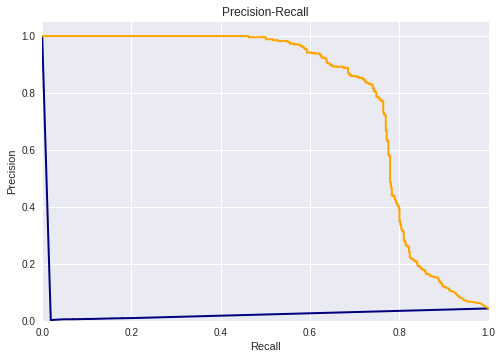

In [58]:
def get_quality(estimator, x, y):
    """
    precision is tp / (tp + fp) -- returning accurate resutls 
    recall is tp / (tp + fn)  --- returning the majority of postiive results
    high recall but low precision returns many results, but most of those predicted labels are incorrect 
    high preciosnn, but low recall returns few results, but most of the resutls returned are corret
    f1 is 2 * ( precsion * recall )  / (precsion + recall)
    """
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .333)
    estimator.fit(x_train, y_train)
    y_pred = estimator.predict(x_test)
    print classification_report(y_test, y_pred, target_names=['nominal','failure'])
    
    y_prob = estimator.predict_proba(x_test)
    ypf = [i[1] for i in y_prob]
    ypn = [i[0] for i in y_prob]
    precision_f, recall_f, thresholds_f = precision_recall_curve(y_test, ypf)
    precision_n, recall_n, thresholds_n = precision_recall_curve(y_test, ypn)
    #plt.plot(recall_n, precision_n, lw=2, color='navy')
    plt.plot(recall_f, precision_f, lw=2, color='black')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0,1.05])
    plt.xlim([0,1.0])
    plt.title('Precision-Recall')
    plt.show()
    return precision_f, recall_f, thresholds_f
    
erf = ExtraTreesClassifier(n_estimators=n_estimators, 
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf, 
                               max_features=max_features,
                               min_impurity_split = min_impurity_split,
                               min_weight_fraction_leaf= min_weight_fraction_leaf)

precision, recall, thresholds = get_quality(erf, x,  y)